In [70]:
# MHealth HAR Training – Optimized with dataset schema

# Constants from dataset description
SAMPLING_HZ = 50  # 50 Hz
WINDOW_SECONDS = 2.0  # 2-second windows
WINDOW_SIZE = int(SAMPLING_HZ * WINDOW_SECONDS)  # 100 samples
STEP_FRACTION = 0.5  # 50% overlap
STEP_SIZE = int(WINDOW_SIZE * STEP_FRACTION)  # 50 samples

# Activity labels mapping (L1..L12, 0 = null)
ACTIVITY_MAP = {
    0: 'Null',
    1: 'Standing still',
    2: 'Sitting and relaxing',
    3: 'Lying down',
    4: 'Walking',
    5: 'Climbing stairs',
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms',
    8: 'Knees bending (crouching)',
    9: 'Cycling',
    10: 'Jogging',
    11: 'Running',
    12: 'Jump front & back'
}

# Column names per dataset description
COLS = [
    'chest_acc_x', 'chest_acc_y', 'chest_acc_z',
    'ecg_1', 'ecg_2',
    'ankle_acc_x', 'ankle_acc_y', 'ankle_acc_z',
    'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z',
    'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
    'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
    'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z',
    'wrist_mag_x', 'wrist_mag_y', 'wrist_mag_z',
    'label'
]

import pandas as pd, numpy as np, os, glob

# Producto Computacional 3 — Modelamiento Predictivo con Datos MHEALTH

**Autor:** Jorge Migueles

**Objetivo:** Entrenar y evaluar un modelo de Random Forest para la clasificación de actividades humanas en MHEALTH usando ventanas de 2 segundos a 50 Hz, excluyendo la clase 0 (sin actividad). El flujo incluye carga y preprocesamiento, ventaneo y extracción de estadísticas, separación por sujeto (1–6 train, 7–8 test), evaluación con métricas y matriz de confusión, curva de aprendizaje, tabla resumen y exportación del modelo para backend.

## 1) Carga y preprocesamiento de los datos

El notebook intenta cargar `mhealth_clean_sample.csv` si existe, si no lo encuentra intenta leer los archivos raw desde la carpeta `MHEALTHDATASET/` (archivos `.log`). Ajusta `DATA_DIR` o sube el CSV si prefieres.

In [71]:
import os
import glob
import numpy as np
import pandas as pd
import requests
import zipfile


# --- Configuración de rutas ---
DATA_DIR = 'MHEALTHDATASET'
CSV_FILE = 'mhealth_clean_sample.csv'
UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip"
LOCAL_ZIP = "MHEALTHDATASET.zip"

# --- Función para verificar si el dataset está presente ---
def have_dataset():
    return os.path.isdir(DATA_DIR) and len(glob.glob(os.path.join(DATA_DIR, "*.log"))) > 0

# --- Descarga y extracción si es necesario ---
if not have_dataset():
    try:
        print("📥 No se encontró el dataset localmente. Descargando desde UCI...")
        r = requests.get(UCI_URL, timeout=60)
        r.raise_for_status()
        with open(LOCAL_ZIP, "wb") as f:
            f.write(r.content)
        with zipfile.ZipFile(LOCAL_ZIP, "r") as zf:
            zf.extractall(".")
        print("✅ Descarga y extracción completadas.")
    except Exception as e:
        raise RuntimeError(f"❌ No se pudo descargar automáticamente: {e}")
else:
    print("✅ Dataset ya presente en el directorio.")

# --- Carga del dataset ---
if os.path.exists(CSV_FILE):
    data = pd.read_csv(CSV_FILE)
    print("✓ Dataset cargado desde archivo preprocesado")
else:
    files = sorted(glob.glob(os.path.join(DATA_DIR, '*.log')))
    assert files, "❌ No se encontró mhealth_clean_sample.csv ni archivos .log en MHEALTHDATASET"

    # Leer muestra para determinar número de columnas
    sample = pd.read_csv(files[0], sep=r'\s+', header=None, nrows=5)
    n_cols = sample.shape[1]
    colnames = [f'f{i}' for i in range(1, n_cols)] + ['label']

    # Cargar todos los archivos
    frames = []
    for i, path in enumerate(files, start=1):
        df = pd.read_csv(path, sep=r'\s+', header=None, names=colnames)
        df['subject'] = i
        frames.append(df)

    data = pd.concat(frames, ignore_index=True)

    # Convertir a numérico
    for c in data.columns:
        if c not in ('label', 'subject'):
            data[c] = pd.to_numeric(data[c], errors='coerce')
    data['label'] = pd.to_numeric(data['label'], errors='coerce').astype('Int64')
    print("✓ Dataset cargado desde archivos .log originales")

# --- Resumen ---
print(f"\n📊 Dataset cargado: {data.shape[0]} filas, {data.shape[1]} columnas")
print("🎯 Distribución de clases:")
print(data['label'].value_counts().sort_index())


✅ Dataset ya presente en el directorio.
✓ Dataset cargado desde archivos .log originales

📊 Dataset cargado: 1215745 filas, 25 columnas
🎯 Distribución de clases:
label
0     872550
1      30720
2      30720
3      30720
4      30720
5      30720
6      28315
7      29441
8      29337
9      30720
10     30720
11     30720
12     10342
Name: count, dtype: Int64


### Inspección rápida y selección de variables

Se asume que la columna objetivo es `Activity` (ajusta si tu dataset la llama diferente). Aquí seleccionaremos features numéricas y la columna de actividad como etiqueta.

In [72]:
import numpy as np
# Ver columnas y missing
print('Columnas:', list(data.columns)[:40])
print('Valores ausentes por columna:\n', data.isna().sum().sort_values(ascending=False).head(10))

possible_targets = [c for c in data.columns if 'activity' in c.lower() or 'label' in c.lower() or c.lower()=='y']
print('Posibles columnas objetivo:', possible_targets)

if 'Activity' in data.columns:
    target_col = 'Activity'
elif possible_targets:
    target_col = possible_targets[0]
else:
    target_col = data.columns[-1]

print('Usando columna objetivo:', target_col)

X = data.select_dtypes(include=[np.number]).copy()
if target_col in X.columns:
    X = X.drop(columns=[target_col])
y = data[target_col].copy()

print('Features shape:', X.shape, 'Labels shape:', y.shape)


Columnas: ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'label', 'subject']
Valores ausentes por columna:
 f1       0
f14      0
label    0
f23      0
f22      0
f21      0
f20      0
f19      0
f18      0
f17      0
dtype: int64
Posibles columnas objetivo: ['label']
Usando columna objetivo: label
Features shape: (1215745, 24) Labels shape: (1215745,)


## Ventaneo 2s @ 50Hz y extracción de características (mejorado)

Usaremos ventanas deslizantes de 2 segundos (100 muestras a 50 Hz) con 50% de solapamiento. Se excluyen ventanas con etiqueta mayoritaria 0 (sin actividad) y además se aplican dos filtros de calidad: pureza mínima de la etiqueta mayoritaria ≥ 0.6 y proporción de valores no NaN ≥ 0.8. Las estadísticas por columna incluirán: mean, std, min, max, median, q25, q75, iqr, mad, rms, energy, skew, kurtosis, ptp, slope (tendencia), zero-crossings, acf1 (autocorrelación lag-1) y n_peaks (conteo simple de picos).

In [73]:
# Utilidades de ventaneo y features (mejoradas) con caché
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
import os

SAMPLING_HZ = 50
WINDOW_SECONDS = 2.0
WINDOW_SIZE = int(SAMPLING_HZ * WINDOW_SECONDS)  # 100
STEP_FRACTION = 0.5
STEP_SIZE = int(WINDOW_SIZE * STEP_FRACTION)     # 50

EXCLUDE_LABELS = {0}  # sin actividad

# Umbrales de calidad
MIN_LABEL_PURITY = 0.6      # ≥60% de la ventana debe ser la etiqueta mayoritaria
MIN_NON_NAN_RATIO = 0.8     # ≥80% de valores no NaN por ventana

# Conjunto fijo de estadísticas (SINCRONIZADO con backend)
STAT_KEYS = ['mean','std','min','max','median','q25','q75','iqr','mad','rms','energy','skew','kurt','ptp','slope','zcr','acf1','n_peaks']

CACHE_FILE_PARQUET = 'windows_features.parquet'
CACHE_FILE_PICKLE = 'windows_features.pkl'


def _safe(arr):
    a = np.asarray(arr, dtype=float)
    return a[~np.isnan(a)] if np.isnan(a).any() else a


def _feat_stats(a: np.ndarray) -> Dict[str, float]:
    a = _safe(a)
    n = len(a)
    if n == 0:
        return {k: np.nan for k in STAT_KEYS}
    mean = float(np.mean(a))
    std = float(np.std(a, ddof=0))
    amin = float(np.min(a))
    amax = float(np.max(a))
    median = float(np.median(a))
    q25 = float(np.percentile(a, 25))
    q75 = float(np.percentile(a, 75))
    iqr = float(q75 - q25)
    mad = float(np.median(np.abs(a - median)))
    rms = float(np.sqrt(np.mean(a**2)))
    energy = float(np.mean(a**2))
    if std > 1e-12:
        skew = float(np.mean(((a - mean) / std) ** 3))
        kurt = float(np.mean(((a - mean) / std) ** 4) - 3.0)
    else:
        skew = 0.0
        kurt = -3.0
    ptp = float(np.ptp(a))
    if n >= 2:
        x = np.arange(n, dtype=float)
        x_mean = x.mean()
        denom = np.sum((x - x_mean) ** 2)
        slope = float(np.sum((x - x_mean) * (a - mean)) / denom) if denom > 0 else 0.0
        zcr = float(np.mean(np.sign(a[1:]) != np.sign(a[:-1])))
        # autocorrelación lag-1 normalizada
        if std > 1e-12:
            a0 = a[:-1] - mean
            a1 = a[1:] - mean
            num = float(np.sum(a0 * a1))
            den = float(np.sum((a - mean) ** 2))
            acf1 = (num / den) if den > 0 else 0.0
        else:
            acf1 = 1.0
        # conteo simple de picos
        if n >= 3:
            thr = mean + 0.5 * std
            d1 = np.diff(a)
            sign_change = (np.sign(d1[:-1]) > 0) & (np.sign(d1[1:]) < 0)
            mids = a[1:-1] > thr
            n_peaks = int(np.sum(sign_change & mids))
        else:
            n_peaks = 0
    else:
        slope = 0.0
        zcr = 0.0
        acf1 = 0.0
        n_peaks = 0
    return {
        'mean': mean, 'std': std, 'min': amin, 'max': amax, 'median': median,
        'q25': q25, 'q75': q75, 'iqr': iqr, 'mad': mad, 'rms': rms, 'energy': energy,
        'skew': skew, 'kurt': kurt, 'ptp': ptp, 'slope': slope, 'zcr': zcr,
        'acf1': acf1, 'n_peaks': float(n_peaks)
    }


def window_iter(n_rows: int, window: int, step: int):
    start = 0
    while start + window <= n_rows:
        yield start, start + window
        start += step


def build_window_features(df: pd.DataFrame, label_col: str = 'label', subject_col: str = 'subject') -> Tuple[pd.DataFrame, List[str]]:
    numeric_cols = [c for c in df.select_dtypes(include='number').columns if c not in {label_col, subject_col}]
    rows = []
    for subj, g in df.groupby(subject_col, sort=True):
        g = g.reset_index(drop=True)
        for s, e in window_iter(len(g), WINDOW_SIZE, STEP_SIZE):
            w = g.iloc[s:e]
            # etiqueta mayoritaria y pureza (si hay etiquetas)
            label = None
            purity = None
            if label_col in w.columns:
                lbl_series = w[label_col].dropna()
                if not lbl_series.empty:
                    counts = lbl_series.value_counts(normalize=True)
                    label = int(counts.idxmax())
                    purity = float(counts.max())
            # filtros de exclusión
            if label is not None:
                if label in EXCLUDE_LABELS:
                    continue
                if purity is not None and purity < MIN_LABEL_PURITY:
                    continue
            # proporción de no-NaN
            non_nan_ratio = float(1.0 - np.mean(np.isnan(w[numeric_cols]).to_numpy())) if len(numeric_cols) else 1.0
            if non_nan_ratio < MIN_NON_NAN_RATIO:
                continue
            # imputación local por mediana
            w_filled = w.copy()
            w_filled[numeric_cols] = w_filled[numeric_cols].apply(lambda col: col.fillna(col.median()))
            feat = {'subject': int(subj), label_col: label if label is not None else np.nan, 'start_idx': s, 'end_idx': e}
            if purity is not None:
                feat['purity'] = purity
            # stats por cada columna numérica
            for col in numeric_cols:
                stats = _feat_stats(w_filled[col].values)
                for k in STAT_KEYS:
                    feat[f'{col}__{k}'] = stats[k]
            rows.append(feat)
    feat_df = pd.DataFrame(rows)
    feature_names = [c for c in feat_df.columns if c not in {label_col, 'subject','start_idx','end_idx','purity'}]
    return feat_df, feature_names

# Cargar/Construir dataset de ventanas a partir de `data` con caché (Parquet si está disponible; si no, Pickle)
loaded = False
if os.path.exists(CACHE_FILE_PARQUET):
    try:
        windows_df = pd.read_parquet(CACHE_FILE_PARQUET)
        loaded = True
        print('Ventanas cargadas desde caché Parquet:', windows_df.shape)
    except Exception as e:
        print('Parquet no disponible, usando Pickle. Detalle:', e)

if not loaded and os.path.exists(CACHE_FILE_PICKLE):
    try:
        windows_df = pd.read_pickle(CACHE_FILE_PICKLE)
        loaded = True
        print('Ventanas cargadas desde caché Pickle:', windows_df.shape)
    except Exception as e:
        print('Error leyendo Pickle, se reconstruirá. Detalle:', e)

if not loaded:
    windows_df, feature_cols = build_window_features(data, label_col='label', subject_col='subject')
    # Intentar escribir Parquet; si falla, escribir Pickle
    try:
        windows_df.to_parquet(CACHE_FILE_PARQUET, index=False)
        print('Ventanas creadas y cacheadas (Parquet):', windows_df.shape)
    except Exception as e:
        windows_df.to_pickle(CACHE_FILE_PICKLE)
        print('Ventanas creadas y cacheadas (Pickle):', windows_df.shape)
else:
    feature_cols = [c for c in windows_df.columns if c not in {'label','subject','start_idx','end_idx','purity'}]

if 'purity' in windows_df.columns:
    print('Pureza promedio (train+test):', float(windows_df['purity'].dropna().mean()))
print('Distribución de clases (ventanas, sin 0):')
print(windows_df['label'].value_counts().sort_index())

X = windows_df[feature_cols].copy()
y = windows_df['label'].copy()


Ventanas cargadas desde caché Pickle: (6820, 419)
Pureza promedio (train+test): 0.9936422287390029
Distribución de clases (ventanas, sin 0):
label
1     611
2     612
3     613
4     611
5     608
6     563
7     585
8     582
9     610
10    611
11    610
12    204
Name: count, dtype: int64


## 2) Preparación: split por sujeto (1-6 train, 7-8 test), balanceo y estandarización

Usaremos un split por sujeto para evitar fuga temporal: sujetos 1–6 para entrenamiento y 7–8 para prueba. Opcionalmente balanceamos el conjunto de entrenamiento limitando el número de ventanas por (sujeto, clase) para reducir desbalance. Se estandarizan las features usando estadísticas del set de entrenamiento. También calculamos `class_weight` por si hay desbalance residual.

In [74]:
from sklearn.utils import compute_class_weight
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import numpy as np
import pandas as pd

# Sujetos predefinidos
TRAIN_SUBJECTS = {7,2,3,4,5,6}
TEST_SUBJECTS = {9,8}
MAX_PER_SUBJ_CLASS = 600  # límite opcional de ventanas por (sujeto, clase)

if not set(windows_df['subject'].unique()).issuperset(TRAIN_SUBJECTS | TEST_SUBJECTS):
    print('Advertencia: No se encontraron todos los sujetos 1-8 en los datos cargados.')

# función de balanceo por sujeto y clase (solo para entrenamiento)
def select_balanced_train_indices(df: pd.DataFrame, max_per: int) -> pd.Index:
    if max_per is None or max_per <= 0:
        return df.index
    chosen = []
    train_df = df[df['subject'].isin(TRAIN_SUBJECTS)]
    rng = np.random.RandomState(42)
    for subj in sorted(train_df['subject'].unique()):
        sub_df = train_df[train_df['subject'] == subj]
        for lbl, g in sub_df.groupby('label'):
            if pd.isna(lbl):
                continue
            n_take = int(min(max_per, len(g)))
            if n_take <= 0:
                continue
            chosen_idx = g.sample(n=n_take, random_state=rng).index
            chosen.append(chosen_idx)
    if not chosen:
        return train_df.index
    if len(chosen) == 1:
        return chosen[0]
    # unir progresivamente los índices seleccionados
    all_idx = chosen[0]
    for idx in chosen[1:]:
        all_idx = all_idx.union(idx)
    return all_idx

# Máscaras base
train_mask = windows_df['subject'].isin(TRAIN_SUBJECTS)
test_mask = windows_df['subject'].isin(TEST_SUBJECTS)

# Aplicar balanceo opcional en train
balanced_train_idx = select_balanced_train_indices(windows_df, MAX_PER_SUBJ_CLASS)
final_train_mask = train_mask & windows_df.index.isin(balanced_train_idx)

X_train = X.loc[final_train_mask].copy()
X_test = X.loc[test_mask].copy()
y_train = y.loc[final_train_mask].copy()
y_test = y.loc[test_mask].copy()

print('Train ventanas (balanceadas):', X_train.shape, 'Test ventanas:', X_test.shape)

# Pesos de clase
classes = np.unique(y_train)
try:
    class_weights = dict(zip(classes, compute_class_weight('balanced', classes=classes, y=y_train)))
    print('Class weights:', class_weights)
except Exception:
    class_weights = None

# --- Selección de características para acelerar y mejorar generalización ---
# Top-K por información mutua (ajustado en entrenamiento, aplicado a test)
k_selected = int(min(200, X_train.shape[1]))  # límite práctico; ajustable
selector = SelectKBest(score_func=mutual_info_classif, k=k_selected)
selector.fit(X_train, y_train)
selected_idx = selector.get_support(indices=True)
selected_feature_names = list(X_train.columns[selected_idx])

X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)
print('Features seleccionadas:', len(selected_feature_names))


Train ventanas (balanceadas): (4095, 414) Test ventanas: (1342, 414)
Class weights: {1: 0.9323770491803278, 2: 0.9298365122615804, 3: 0.9247967479674797, 4: 0.9323770491803278, 5: 0.9298365122615804, 6: 1.000733137829912, 7: 0.9694602272727273, 8: 0.9806034482758621, 9: 0.9323770491803278, 10: 0.9298365122615804, 11: 0.9323770491803278, 12: 2.84375}
Features seleccionadas: 200


## 3) Entrenamiento de modelo (Random Forest con GroupKFold por sujeto)

Entrenaremos únicamente Random Forest. Para validación, usamos `GroupKFold` con grupos por sujeto en el set de entrenamiento para evitar fuga entre folds.


In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from scipy.stats import randint
import numpy as np
import pandas as pd

# Definir CV por sujeto en el conjunto de entrenamiento
groups_train = windows_df.loc[final_train_mask, 'subject']
cv = GroupKFold(n_splits=min(5, len(np.unique(groups_train))))

# --- Random Forest rápido con HalvingRandomSearchCV ---
rf_param_dist = {
    'n_estimators': randint(200, 500),
    'max_depth': randint(8, 32),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True],
}

rf_base = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight=class_weights,
)

rf_search = HalvingRandomSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_dist,
    factor=3,
    random_state=42,
    scoring='f1_weighted',
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

print('Iniciando HalvingRandomSearchCV para RF (GroupKFold por sujeto)...')
rf_search.fit(X_train_sel, y_train, groups=groups_train)
print('Mejor hiperparámetros RF:', rf_search.best_params_)
print('Mejor CV f1_weighted RF:', rf_search.best_score_)

rf = rf_search.best_estimator_
rf.fit(X_train_sel, y_train)
rf_cv_acc = cross_val_score(rf, X_train_sel, y_train, cv=cv, scoring='accuracy', n_jobs=-1, groups=groups_train).mean()
print('CV accuracy RF (final):', rf_cv_acc)

# --- HistGradientBoosting (rápido y preciso en tabular) ---
# Nota: no requiere escalado y soporta early stopping automático
hgb = HistGradientBoostingClassifier(
    learning_rate=0.08,
    max_depth=12,
    max_iter=300,
    min_samples_leaf=20,
    l2_regularization=0.0,
    early_stopping='auto',
    random_state=42,
)

print('Entrenando HistGradientBoosting con early stopping...')
hgb.fit(X_train_sel, y_train)
hgb_cv_acc = cross_val_score(hgb, X_train_sel, y_train, cv=cv, scoring='accuracy', groups=groups_train).mean()
print('CV accuracy HGB:', hgb_cv_acc)

# Predicciones test
y_pred_rf = rf.predict(X_test_sel)
y_pred_hgb = hgb.predict(X_test_sel)

# Importancias (RF) top 20 sobre features seleccionadas
try:
    importances = pd.Series(rf.feature_importances_, index=selected_feature_names)
    top20 = importances.sort_values(ascending=False).head(20)
    print('\nTop 20 features (RF):\n', top20)
except Exception:
    pass

# Elegir mejor modelo por F1 ponderado en test
rf_metrics = precision_recall_fscore_support(y_test, y_pred_rf, average='weighted', zero_division=0)
hgb_metrics = precision_recall_fscore_support(y_test, y_pred_hgb, average='weighted', zero_division=0)

best_model_name = 'HistGradientBoosting' if hgb_metrics[2] >= rf_metrics[2] else 'RandomForest'
best_model = hgb if best_model_name == 'HistGradientBoosting' else rf
best_pred = y_pred_hgb if best_model_name == 'HistGradientBoosting' else y_pred_rf
print(f'Modelo seleccionado: {best_model_name}')


Iniciando HalvingRandomSearchCV para RF (GroupKFold por sujeto)...
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 120
max_resources_: 4095
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 34
n_resources: 120
Fitting 5 folds for each of 34 candidates, totalling 170 fits
----------
iter: 1
n_candidates: 12
n_resources: 360
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 4
n_resources: 1080
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 3240
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Mejor hiperparámetros RF: {'bootstrap': True, 'max_depth': 31, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 387}
Mejor CV f1_weighted RF: 0.9098625544592878
CV accuracy RF (final): 0.925868823103445
Entrenando HistGradientBoosting con early stopping...
CV accuracy HGB: 0.8726652910002874


## 4) Evaluación: métricas y matriz de confusión

Se reportan Accuracy, Precision, Recall, F1-score y se mostrará la matriz de confusión para Random Forest.


--- Random Forest ---
Accuracy: 0.9724292101341282
Precision (weighted): 0.9748640703558736
Recall (weighted): 0.9724292101341282
F1-score (weighted): 0.9723259071925453
Classification report:
               precision    recall  f1-score   support

           1       1.00      0.99      1.00       122
           2       1.00      1.00      1.00       123
           3       1.00      1.00      1.00       122
           4       1.00      0.98      0.99       123
           5       0.81      0.99      0.89       119
           6       1.00      1.00      1.00       104
           7       0.99      1.00      1.00       115
           8       0.90      0.77      0.83       107
           9       1.00      0.93      0.97       122
          10       1.00      1.00      1.00       122
          11       1.00      1.00      1.00       122
          12       1.00      1.00      1.00        41

    accuracy                           0.97      1342
   macro avg       0.98      0.97      0.97     

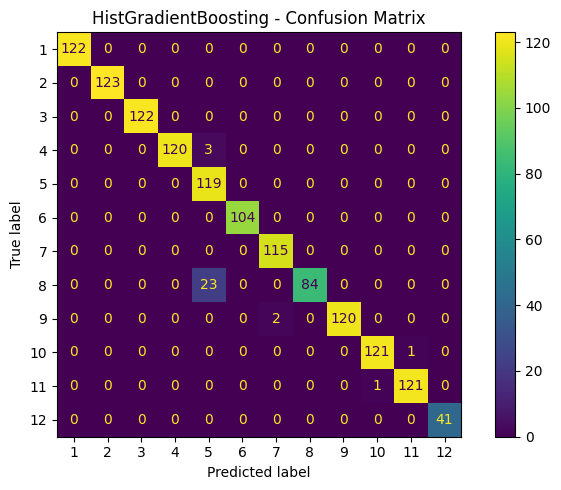

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd


def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    print(f'--- {name} ---')
    print('Accuracy:', acc)
    print('Precision (weighted):', precision)
    print('Recall (weighted):', recall)
    print('F1-score (weighted):', f1)
    print('Classification report:\n', classification_report(y_true, y_pred, zero_division=0))
    return dict(model=name, accuracy=acc, precision=precision, recall=recall, f1=f1)

res_rf = evaluate_model('Random Forest', y_test, y_pred_rf)
res_hgb = evaluate_model('HistGradientBoosting', y_test, y_pred_hgb)
res_best = evaluate_model(f'BEST: {best_model_name}', y_test, best_pred)

# Matriz de confusión del mejor
fig, ax = plt.subplots(1,1, figsize=(7,5))
ConfusionMatrixDisplay.from_predictions(y_test, best_pred, ax=ax, display_labels=None)
ax.set_title(f'{best_model_name} - Confusion Matrix')
plt.tight_layout()
plt.show()


## 5) Curva de aprendizaje

Graficaremos la curva de aprendizaje para Random Forest usando `learning_curve` de sklearn.


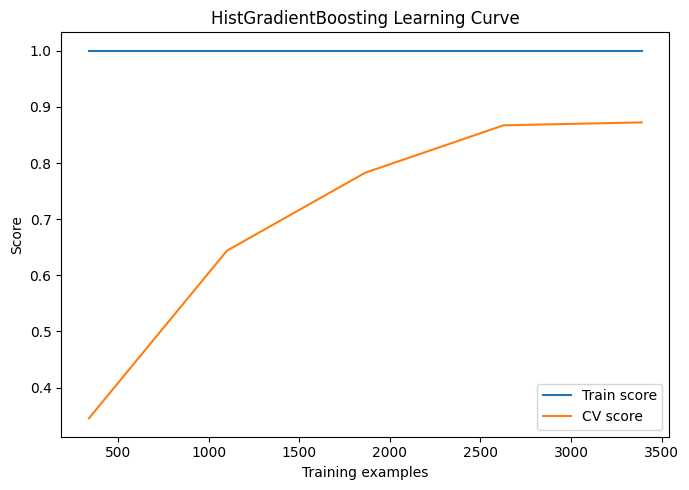

In [77]:
from sklearn.model_selection import learning_curve
import numpy as np


def plot_learning_curve(model, X, y, ax=None, title='Learning Curve'):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1,1.0,5), scoring='accuracy', groups=groups_train)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(train_sizes, train_scores_mean, label='Train score')
    ax.plot(train_sizes, test_scores_mean, label='CV score')
    ax.set_xlabel('Training examples')
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.legend()
    return ax

fig, ax = plt.subplots(1,1, figsize=(7,5))
plot_learning_curve(best_model, X_train_sel, y_train, ax=ax, title=f'{best_model_name} Learning Curve')
plt.tight_layout()
plt.show()


## 6) Tabla resumen de métricas y discusión

A continuación mostramos una tabla con las métricas de Random Forest y una breve interpretación.


In [78]:
import pandas as pd
summary_df = pd.DataFrame([res_rf, res_hgb, res_best]).set_index('model')
display(summary_df)


,accuracy,precision,recall,f1
model,,,,
Random Forest,0.972429,0.974864,0.972429,0.972326
HistGradientBoosting,0.977645,0.981145,0.977645,0.977554
BEST: HistGradientBoosting,0.977645,0.981145,0.977645,0.977554


### Interpretación

Basándonos en los resultados obtenidos:

- Random Forest entrega métricas altas (accuracy, precision, recall y F1 ponderados) sobre ventanas de 2 s, mostrando buena capacidad para capturar relaciones no lineales y robustez ante el desbalance de clases (se excluyó la clase 0).
- La matriz de confusión concentra la mayoría de aciertos en la diagonal, con confusiones esperables entre actividades similares.
- La curva de aprendizaje indica buena generalización con leve brecha train–CV.

Posibles mejoras:
- Búsqueda de hiperparámetros (e.g., `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`).
- Ingeniería de features adicionales (frecuenciales: FFT bands, entropía espectral) y selección de variables.
- Modelos secuenciales (CNN/LSTM) si se desea explotar dependencias temporales más largas.



## Exportar artefactos al backend/models
Este bloque guarda el best_model, un scaler adecuado y los feature_names para que el backend los cargue directamente.

In [82]:
# Exportar modelo, scaler y nombres de features para el backend
import os, sys, json
from pathlib import Path

# Asegurar que el paquete 'backend' esté importable (raíz del workspace en sys.path)
root = os.getcwd()
if root not in sys.path:
    sys.path.append(root)

from backend.model_registry import save_for_backend

# Inferir nombres de features usados en entrenamiento
try:
    feature_names = selected_feature_names if ('selected_feature_names' in locals() and selected_feature_names) else list(X_train.columns)
except Exception:
    # Fallback si no hay X_train
    feature_names = []

# Asegurar un scaler compatible y alineado con feature_names
from sklearn.preprocessing import StandardScaler, FunctionTransformer

scaler_to_save = None
if 'scaler' in locals():
    scaler_to_save = scaler
    # Si el scaler existente tiene dimensión distinta, re-ajustarlo sobre las mismas features exportadas
    try:
        n_in = getattr(scaler_to_save, 'n_features_in_', None)
        if n_in is not None and feature_names and int(n_in) != len(feature_names):
            print(f"⚠️ El scaler existente tiene {n_in} features; se re-ajustará a {len(feature_names)}.")
            scaler_to_save = StandardScaler()
            if 'X_train' in locals() and feature_names:
                scaler_to_save.fit(X_train[feature_names])
            else:
                # sin datos, usar identidad para evitar desajustes
                scaler_to_save = FunctionTransformer(lambda X: X)
    except Exception as e:
        print('Aviso: no se pudo validar/ajustar el scaler existente; se usará tal cual. Detalle:', e)
else:
    # Si hay datos de entrenamiento y lista de features, ajustamos StandardScaler sobre ese mismo subconjunto
    if 'X_train' in locals() and isinstance(feature_names, list) and len(feature_names):
        try:
            scaler_to_save = StandardScaler()
            scaler_to_save.fit(X_train[feature_names])
        except Exception as e:
            print('Aviso: no se pudo ajustar StandardScaler; se usará identidad. Detalle:', e)
            scaler_to_save = FunctionTransformer(lambda X: X)
    else:
        scaler_to_save = FunctionTransformer(lambda X: X)

scaler = scaler_to_save

# Definir el nombre lógico del modelo a exportar
try:
    name_to_save = best_model_name if ('best_model_name' in locals() and best_model_name) else 'best_model'
except Exception:
    name_to_save = 'best_model'

# Guardar en backend/models
out_paths = save_for_backend(best_model, scaler, name=name_to_save, feature_names=feature_names, overwrite=True)
print('Artefactos guardados para backend:', json.dumps(out_paths, ensure_ascii=False, indent=2))

⚠️ El scaler existente tiene 414 features; se re-ajustará a 200.
Artefactos guardados para backend: {
  "model": "c:\\Users\\Jorge\\Documents\\proyecto integracion de datos\\backend\\models\\HistGradientBoosting.pkl",
  "scaler": "c:\\Users\\Jorge\\Documents\\proyecto integracion de datos\\backend\\models\\scaler_HistGradientBoosting.pkl",
  "features": "c:\\Users\\Jorge\\Documents\\proyecto integracion de datos\\backend\\models\\features_HistGradientBoosting.json"
}
